<a href="https://colab.research.google.com/github/Ganryuu/TSYP_X_CS_Challenge/blob/master/CS_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libraries 
import os
import zipfile
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image
from tqdm import tqdm
from dataclasses import dataclass
from keras.models import Model, load_model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.layers import Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras import backend as K
from keras import optimizers
from keras import metrics
import datetime
import glob
import random
from pandas import DataFrame
import pandas as pd
from skimage.feature import match_template


In [ ]:
image_folder = '/content/drive/My Drive/cs/24/'
"""
image folder contains the THEMIS 24 images in their original state
"""
print(os.path.exists(image_folder))

True


In [ ]:
""" this function checks if images are grayscale """ 
 # here we just make sure if our images has 3 rgb channels or one grayscale one to know how to adapt our next code smaples
def isgray(imgpath):
    img = cv2.imread(imgpath)
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    return False
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
"""
here we grab one tile to run some tests on it and see how we should advance from now on 
"""
images = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
img = Image.open(os.path.join(image_folder, images[3]))
data = img.load()

width, height = img.size
print(img.size)

(7680, 7680)


**Dealing with the black streaks in Data**

Here we fill out missing pixels with the average pixel color of each tile . 

In [ ]:
"""
this loops around all the 24 THEMIS  data images 
"""

for i in range(len(images)) : 
  print(f'##### img {i}/{len(images)} has started processing #####')
  img = cv2.imread(os.path.join(image_folder,images[i]))
  #converting image to rgb channels
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  avg_px_value = np.average(img, axis = (0,1))
  # Make all black pixels the color of the average pixel of that tile
  img[np.all(img == (0, 0 , 0), axis=-1)] = tuple([ avg_px_value])
  img = rgb2gray(img)
  # Save processed image result in new folder in drive
  cv2.imwrite(f'/content/drive/My Drive/cs/processed_images/{images[i]}',img)
 

**Processing TSV file of Annotation data**

in the original Robbins & Hynek (RH2012) annotations we have latitude and longitude values for every single detection thus the ability to filter out the range we want as mentioned in the attached paper  ` ±30° latitude  and from 0° to 360° longitude`

In [ ]:

 
"""   
please make sure to change minimum latitude and longitude 
 to extract specific tile values 
this should be done with all tiles from within the range of 
-30 - 0 : 0 - 30 in latitude 
and 
0 - 30 - 60 .. 300 - 330 - 360 in longitude

      variable_mapping = {
    'CRATER_ID' : 0 , 
    'LATITUDE_CIRCLE_IMAGE' : 1 , 
    'LONGITUDE_CIRCLE_IMAGE' : 2 , 
    'DIAM_CIRCLE_IMAGE' : 5 

}
"""
#this example gets us the tile -30 - 0 - 0 - 30 
MINLAT = -30 # minimum latitude 
MAXLAT = 0
MINLON = 0  # minimum longitude 
MAXLON = 30
PATH_TSV = ''
with open("./content/drive/My Drive/cs/RobbinsCraters_20121016.tsv", 'r') as file: 
  with open(f"CSV_Tile_{MINLAT}_{MAXLAT}_{MINLON}_{MAXLON}.csv", 'w') as csv_file: # opening as w mode to create file if does not exist and append to it if exists already  
      cols = [ 'Lat',  'Long',  'Diameter (km)'  ]
      line = file.readline()
      csv_file.write(','.join(str(z) for z in cols)+'\n')# here we add first the column names for our files 
      for line in file:    
        [id, lat, lon, diam] = [line.split('\t')[i] for i in [0,1,2,5] ]
        if (MINLAT <= float(lat) and float(lat) <= MAXLAT and MINLON <= float(lon) and float(lon) <= MAXLON): 
                 csv_file.write(','.join(str(z) for z in [id, lat, lon, diam])+'\n')
print(f"CSV_Tile_{MINLAT}_{MAXLAT}_{MINLON}_{MAXLON} Has been generated sucessfully !")

In [ ]:
"""
data class decorator enables us to define global class variables to use later on with Training and match_template utils 
"""
@dataclass
class Vars:
    #HERE we can change our vars to test or change our threshholds while working with either the data imports or the U-Net Architecture
    EPOCHS  =  500 
    SEED = 42 
    VERBOSE = True 
    randomized = True 

In [ ]:
@dataclass 
class Defaults:
    #These defaullts were fine tuned by the Deep Moon Team for more info visit  : github/deepMoon 
    longlat_thresh2_ = 1.8
    rad_thresh_ = 1.0
    template_thresh_ = 0.5
    minrad_ = 6
    maxrad_ = 140
    target_thresh_ = 0.1
    rw_ = 4 

**glob.glob** : 
(short for global) is used to return all file paths that match a specific pattern. We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the filename matches a certain pattern by using wildcard characters.
consider it like a regex file filer in LINUX

In [ ]:
#passing path a a parameter to grab files with the same name chriterion 

def grab_files_list(path, verbose=True):
    arr = glob.glob(path) #(glob.glob("Robbins_Dataset/synth_out/extracted_04-16km_on_blur2/*.png"))
    arr.sort()
    if (verbose):
        print(len(arr))
        print(arr)
        
    return arr
#grab_files list "grabs the files before training"

In [ ]:
"""
loadIM is a utility function to load images that we will use for either training , validation or testting 
fname : file name : the name of the THEMIS data tile 
tname : tile name : the name of the TARGET data file being the black and white masked craters 
data , target : empty arrays to fill in our data distribution with 
step : here we are going to divice each 7680 px THEMIS tile by 15 which results in 512 px by 512 px iamges to train with 
"""

def loadIm(fname, tname, data, target, step=512, newpx = 512, px = 7680):    
    im = plt.imread(fname)
    
    print('max: ' + str(im.max()) + ', min: ' + str(im.min()) + ', mean: ' + str(im.mean()))
    tim = 1*(plt.imread(tname)>0)#makes values of target binary
    
  
    
    print(im.shape)
    print(tim.shape)
    for y in range(0,px,step): #no need to sub 512 b/c px are mult of 512
        for x in range(0,px,step):
            data.append(im[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))
            target.append(tim[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))

In [ ]:
def coord2pix(cx, cy, cdim, imgdim, origin="upper"):
    """Converts coordinate x/y to image pixel locations.

    Parameters
    ----------
    cx : float or ndarray
        Coordinate x.
    cy : float or ndarray
        Coordinate y.
    cdim : list-like
        Coordinate limits (x_min, x_max, y_min, y_max) of image.
    imgdim : list, tuple or ndarray
        Length and height of image, in pixels.
    origin : 'upper' or 'lower', optional
        Based on imshow convention for displaying image y-axis. 'upper' means
        that [0, 0] is upper-left corner of image; 'lower' means it is
        bottom-left.

    Returns
    -------
    x : float or ndarray
        Pixel x positions.
    y : float or ndarray
        Pixel y positions.
    """

    x = imgdim[0] * (cx - cdim[0]) / (cdim[1] - cdim[0])

    if origin == "lower":
        y = imgdim[1] * (cy - cdim[2]) / (cdim[3] - cdim[2])
    else:
        y = imgdim[1] * (cdim[3] - cy) / (cdim[3] - cdim[2])

    return x, y

In [ ]:
data_path = '/content/drive/My Drive/cs/processed_images/' # processed images contains clean THEMIS images after processing black zones 
target_path = '/content/drive/My Drive/cs/target_images/' # target images contains masked target images ( the white circles on the black background : here we chose the 4px edge thickness images)

# data_arr =[f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
# target_arr = [f for f in os.listdir(target_path) if os.path.isfile(os.path.join(target_path, f))]
data_arr =[f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
target_arr = [f for f in os.listdir(target_path) if os.path.isfile(os.path.join(target_path, f))]
data_arr.sort()
target_arr.sort() 
print(data_arr)

print(target_arr)

['thm_dir_N-30_000.png', 'thm_dir_N-30_030.png', 'thm_dir_N-30_060.png', 'thm_dir_N-30_090.png', 'thm_dir_N-30_120.png', 'thm_dir_N-30_150.png', 'thm_dir_N-30_180.png', 'thm_dir_N-30_210.png', 'thm_dir_N-30_240.png', 'thm_dir_N-30_270.png', 'thm_dir_N-30_300.png', 'thm_dir_N-30_330.png', 'thm_dir_N00_000.png', 'thm_dir_N00_030.png', 'thm_dir_N00_060.png', 'thm_dir_N00_090.png', 'thm_dir_N00_120.png', 'thm_dir_N00_150.png', 'thm_dir_N00_180.png', 'thm_dir_N00_210.png', 'thm_dir_N00_240.png', 'thm_dir_N00_270.png', 'thm_dir_N00_300.png', 'thm_dir_N00_330.png']
['thm_dir_N-30_000_-30_0_0_30_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_030_-30_0_30_60_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_060_-30_0_60_90_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_090_-30_0_90_120_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_120_-30_0_120_150_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_150_-30_0_150_180_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_180_-30_0_-180_-150_2_32_km_segrng_4_edge.png', 'thm_dir_N-30_210_-3

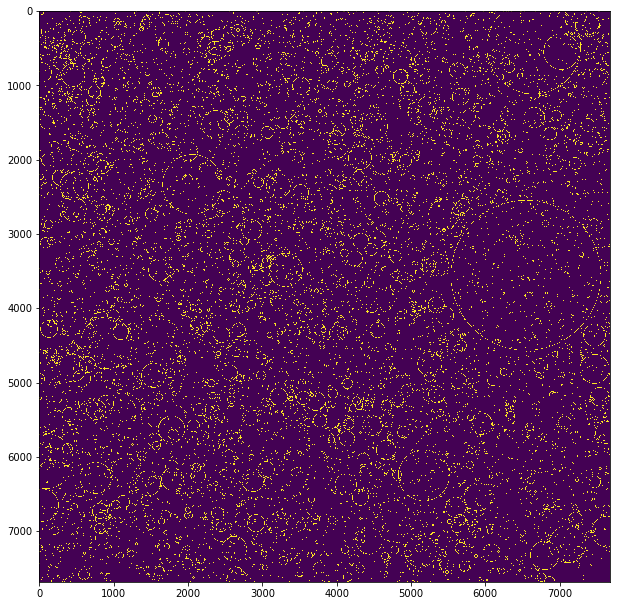

In [ ]:
"""
this tile printing is just a THEMIS data image converted to a numpy array then using a threshhold pointing out the different craters , this was done jsut  for checking and testing 
"""

In [ ]:
"""
given the number of tiles ( in our experiment being 24) randomizing the sorted arrays that contain file names with the same seed to get the same results each time 
change random seed in the upper dataclass cell to get 
"""
def get_tile_order(num_tiles):
        rand_arr = list(range(num_tiles))

        if(Vars.randomized):
            random.seed(Vars.SEED)
            random.shuffle(rand_arr)
        else:
            rand_arr
        print(rand_arr ,"this is the random arr ")
        return rand_arr

In [ ]:
"""
setup_data_bins imports the THEMIS dataset images , and their corresponding target ( in this case being the black and white masked craters widh 4px edge thickness)
""" 

def setup_data_bins(num_train, num_val, num_test, px=7680):
        num_tiles = len(data_arr)
        print(num_tiles)
        if((num_train + num_val + num_test) > num_tiles):
            print('Data bin distribution exceeds available tiles')
        else:
            tile_order_arr = get_tile_order(num_tiles)
            print(tile_order_arr)
            print(type(tile_order_arr))
            if (len(data_arr) == len(target_arr)):
                #make training set
                global train_dataset 
                global train_target 
                train_dataset = []
                train_target = []
                for f in tile_order_arr[0:num_train]:  
                    # loadIm(data_arr[f], target_arr[f], train_dataset, train_target, px=px)
                    # loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), train_dataset, train_target, px=px)
                    loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), train_dataset, train_target, px=px)  
                #changes values from [0,1] to [-1,1], convert to numpy array
                train_dataset = 2*np.array(train_dataset)-1 
                #convert to numpy array
                train_target = np.array(train_target)

                #debugging
                print('Tile #' + str(f))
                print(data_arr[f])  
                print(target_arr[f])
                print(train_dataset.shape)
                print(train_target.shape)
                
                #make validation set
                global val_dataset 
                global val_target 
                val_dataset = []
                val_target = []
                for f in tile_order_arr[num_train:(num_train+num_val)]:    
                    # loadIm(data_arr[f], target_arr[f], val_dataset, val_target, px=px)
                    # loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), val_dataset, val_target, px=px)
                    loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), val_dataset, val_target, px=px)  
                #changes values from [0,1] to [-1,1], convert to numpy array
                val_dataset = 2*np.array(val_dataset)-1 
                #convert to numpy array
                val_target = np.array(val_target)

                #debugging
                print('Tile #' + str(f))
                print(data_arr[f])  
                print(target_arr[f])
                print(val_dataset.shape)
                print(val_target.shape)

                #TODO: make test set  : done 
                global test_dataset 
                global test_target 
                test_dataset = []
                test_target = [] 
                # for f in tile_order_arr[n]
                #make make test set
               
                for f in tile_order_arr[num_val+num_train:(num_val+num_test+num_train)]:    
                    # loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), test_dataset, test_target, px=px)
                    loadIm(os.path.join(data_path,data_arr[f]), os.path.join(target_path,target_arr[f]), test_dataset, test_target, px=px)                
                #changes values from [0,1] to [-1,1], convert to numpy array
                test_dataset = 2*np.array(test_dataset)-1 
                #convert to numpy array
                test_target = np.array(test_target)

                #debugging
                print('Tile #' + str(f))
                print(data_arr[f])  
                print(target_arr[f])
                print(test_dataset.shape)
                print(test_target.shape)
                print(f"this is it {len(test_dataset),len(val_dataset),len(train_dataset)}")
            else: 
                print('Lists of files for the filled and seg images were different sizes. ' + 
                      'No training and test bins created.')

In [ ]:
setup_data_bins(12,8,4)

24
[15, 5, 18, 23, 13, 10, 17, 11, 14, 16, 1, 12, 21, 6, 9, 2, 22, 4, 19, 7, 8, 0, 3, 20] this is the random arr 
[15, 5, 18, 23, 13, 10, 17, 11, 14, 16, 1, 12, 21, 6, 9, 2, 22, 4, 19, 7, 8, 0, 3, 20]
<class 'list'>
max: 1.0, min: 0.003921569, mean: 0.49013525
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49268788
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49154636
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49044687
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49136302
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49362817
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.4903394
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.4932028
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.4922217
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49146298
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49502307
(7680, 7680)
(7680, 7680)
max: 1

In [ ]:
"""
due to lack of resources and time we only opted to pick the unet5 considering the good results it showed in the original paper 
p.s : training this architecure twice ( one for expirmenet and the other for the base mdoel cost about 200 units in computational power of a 32gb NVIDIA A100 approx 22$ in premium gpu price)
"""

def unet5():
    ACT = 'relu'
    KERN_SIZE = 11
    FILTERS=[16,24,32,48,64,96,128,128]
    z1 = Input(shape=(512,512,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

In [ ]:
model = unet5() 
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(adam, loss = 'binary_crossentropy', metrics=['acc']) 
model.fit(train_dataset,train_target,batch_size = 10, epochs=10, validation_data=(val_dataset,val_target), shuffle=True)


z1: (None, 512, 512, 1)
z2: (None, 512, 512, 16), 
p2: (None, 256, 256, 16)
z3: (None, 256, 256, 24), 
p3: (None, 128, 128, 24)
z4: (None, 128, 128, 32), 
p4: (None, 64, 64, 32)
z5: (None, 64, 64, 48)


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  1952        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 256, 256, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

In [ ]:
def unet6():
    ACT = 'relu'
    KERN_SIZE = 7
    FILTERS=[16,24,32,48,64,96,128,128]
    FILTERS = [i * 2 for i in FILTERS]
    
    z1 = Input(shape=(512,512,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

In [ ]:
model_unet_6 = unet6() 
adam = optimizers.Adam(learning_rate=1e-4)
model_unet_6.compile(adam, loss = 'log_loss', metrics=['acc']) 
history_unet_6 = model.fit(train_dataset,train_target,batch_size = 10, epochs=500, validation_data=(val_dataset,val_target), shuffle=True)

z1: (None, 512, 512, 1)
z2: (None, 512, 512, 32), 
p2: (None, 256, 256, 32)
z3: (None, 256, 256, 48), 
p3: (None, 128, 128, 48)
z4: (None, 128, 128, 64), 
p4: (None, 64, 64, 64)
z5: (None, 64, 64, 96)
Epoch 1/500
20/20 [==============================] - 4s 195ms/step - loss: 0.0125 - acc: 0.9945 - val_loss: 1.1640 - val_acc: 0.9802
Epoch 2/500
20/20 [==============================] - 4s 194ms/step - loss: 0.0124 - acc: 0.9946 - val_loss: 1.1318 - val_acc: 0.9802
Epoch 3/500
20/20 [==============================] - 4s 194ms/step - loss: 0.0128 - acc: 0.9945 - val_loss: 1.1344 - val_acc: 0.9804
Epoch 4/500
20/20 [==============================] - 4s 194ms/step - loss: 0.0132 - acc: 0.9943 - val_loss: 1.1414 - val_acc: 0.9805
Epoch 5/500
20/20 [==============================] - 4s 194ms/step - loss: 0.0126 - acc: 0.9945 - val_loss: 1.2107 - val_acc: 0.9808
Epoch 6/500
20/20 [==============================] - 4s 194ms/step - loss: 0.0131 - acc: 0.9944 - val_loss: 1.1869 - val_acc: 0.9803
E

In [ ]:
#saving our model and it's weights
model.save('/content/drive/My Drive/cs/models/Unet_5_4px_edge.h5')


In [ ]:
model = load_model('/content/drive/My Drive/cs/models/Unet_5_4px_edge.h5')

In [ ]:
"""
evaluating our model on the test set 
"""
results = model.evaluate(test_dataset, test_target, batch_size=10)

90/90 [==============================] - 13s 45ms/step - loss: 0.0419 - acc: 0.9879



drawing the circles using opencv
Python: cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]]) → img


Parameters:	
img – Image where the circle is drawn.
center – Center of the circle.
radius – Radius of the circle.
color – Circle color.
thickness – Thickness of the circle outline, if positive. Negative thickness means that a filled circle is to be drawn.
lineType – Type of the circle boundary. See the line() description.
shift – Number of fractional bits in the coordinates of the center and in the radius value.
The function circle draws a simple or filled circle with a given center and radius.


In [ ]:
def remake_tile(images, tile_size=7680, stp=512, SAVE=False, SHOW=False, img_fn=None):
    #figure out the grid size
    num_images = len(images)
    grid_size = int(np.sqrt(num_images))
    #stp = 512
    
    #make list of coordinates 
    coords = []
    for x in range(grid_size):
        for y in range(grid_size):
            coords.append([x*stp, y*stp])
    grid_tile = np.zeros((tile_size,tile_size))

    #place each subtile in the larger tile
    for i, im in enumerate(images):
        grid_tile[coords[i][1]:coords[i][1]+stp,coords[i][0]:coords[i][0]+stp] = im[:,:,0]
        
    if(SHOW):
        plt.imshow(grid_tile)
        plt.gcf().set_size_inches((12,12))
        plt.show()
    
    if(SAVE and img_fn is not None):
        plt.imsave(img_fn+'.png',grid_tile)
        
    return grid_tile 
def four_image(data_image, targ_image, pred_image, find_image, start_x=0, 
               start_y=0, wid_ht=1024, img_fn=None, SAVE=False, SHOW=True):
    #Show Subset of Tile
    sx=start_x; sy=start_y; swh=wid_ht
    
    plt.subplot(2,2,1)
    plt.title('Data')
    plt.imshow(data_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,2)
    plt.title('Target')
    plt.imshow(targ_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,3)
    plt.title('NN Prediction')
    plt.colorbar()
    plt.imshow(pred_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,4)
    plt.title('Crater Finder Output')
    #plt.colorbar()
    plt.imshow(find_image[sx:sx+swh, sy:sy+swh])

    plt.gcf().set_size_inches((12,12))
    
    if(SAVE and img_fn is not None):
        plt.imsave(img_fn+'.png',grid_tile)
    
    if(SHOW):
        plt.show()
def run_match_one_tile( data_fn, targ_fn, csv_px_fn): #move this out of self-land        
        data = [] # the training data array
        target = [] # the target data array 

        loadIm(data_fn, targ_fn, data, target, step=512, newpx = 512, px = 7680)

        data = 2*np.array(data)-1
        target = np.array(target)

        print(data.shape)

        # Load model
        #fn_model = 'models/model_v13d_epochs_500_20180510_0458.h5'# d_epochs_500_20180508_0343.h5' #selected arbitrarily, v13a didn't work?
        #mod = load_model(fn_model)
        # load / bring your odel here so you can .predict later on 
        mod = model
       
       

        # Run model on one tile's worth of data
        outs = mod.predict(data)
        print('Prediction finished ') 
       
            
        #Make the model output back into a tile
        tile_pred = remake_tile(outs, tile_size=7680, SHOW=False)
        
        #Make the orig data & target back into a tile (this should match the input target)
        tile_data = remake_tile(data, tile_size=7680, SHOW=False)
        tile_targ = remake_tile(target, tile_size=7680, SHOW=False)
       
      
        
        #make copy of tile_pred *because the template match changes the np array directly
        copy_tile_pred = np.copy(tile_pred)
        
        #call crater_match
        tile_crater_coords = template_match_t(copy_tile_pred, minrad=6, maxrad=150,
                 longlat_thresh2=Defaults.longlat_thresh2_, rad_thresh=Defaults.rad_thresh_,
                 template_thresh=Defaults.template_thresh_,
                 target_thresh=Defaults.target_thresh_, rw=Defaults.rw_)
        
        
        
        #make image showing comparison 
        #crater_list_to_image(crater_array, img_size=2048)
        tile_found = crater_list_to_image(tile_crater_coords, img_size=7680)
        
        #four_image(data_image, targ_image, pred_image, find_image, start_x=0, start_y=0, wid_ht=1024)
        four_image(tile_data, tile_targ, tile_pred, tile_found, start_x=0, start_y=0, wid_ht=1024)
        
        return tile_pred, tile_crater_coords 

def crater_list_to_image(crater_array, img_size=7680):
    craters_found_img = np.zeros((img_size,img_size))
    for i in range(len(crater_array)):
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 4
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        cv2.circle(craters_found_img,(x_ctr,y_ctr), r, brightness, thick) 
        #print(x_ctr)
    
    plt.gcf().set_size_inches((12,12))
    plt.imshow(craters_found_img)
    plt.show()
    return craters_found_img

In [ ]:
def template_match_t2c(self, target, csv_coords, templ_coords=None, minrad=6, maxrad=150,
                           longlat_thresh2=Defaults.longlat_thresh2_,
                           rad_thresh=Defaults.rad_thresh_, template_thresh=Defaults.template_thresh_,
                           target_thresh=Defaults.target_thresh_, rw=Defaults.rw_, rmv_oor_csvs=0):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target and
        compares the resulting detections to the corresponding human-counted crater
        data.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        csv_coords : array
            Human-counted crater coordinates (in pixel units).
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        rmv_oor_csvs : boolean, flag
            If set to 1, remove craters from the csv that are outside your
            detectable range.
        Returns
        -------
        N_match : int
            Number of crater matches between your target and csv.
        N_csv : int
            Number of csv entries
        N_detect : int
            Total number of detected craters from target.
        maxr : int
            Radius of largest crater extracted from target.
        err_lo : float
            Mean longitude error between detected craters and csvs.
        err_la : float
            Mean latitude error between detected craters and csvs.
        err_r : float
            Mean radius error between detected craters and csvs.   #""""""
        #    Returns
        #    -------
        #    N_match : int
        #        Number of crater matches between your target and csv.
        #    N_csv : int
        #        Number of csv entries
        #    N_detect : int
        #        Total number of detected craters from target.
        #    maxr : int
        #        Radius of largest crater extracted from target.
        #    err_lo : float
        #        Mean longitude error between detected craters and csvs.
        #    err_la : float
        #        Mean latitude error between detected craters and csvs.
        #    err_r : float
        #        Mean radius error between detected craters and csvs.
        #    frac_dupes : float
        #""""""
        frac_dupes : float
            Fraction of craters with multiple csv matches.
        """
        # get coordinates from template matching IF they are not passed
        if(templ_coords is None):
            templ_coords = template_match_t(target, minrad, maxrad, longlat_thresh2,
                                        rad_thresh, template_thresh, target_thresh, rw)
        else:
            print('Found craters: ' )
          

        # find max detected crater radius
        maxr = 0
        if len(templ_coords > 0):
            maxr = np.max(templ_coords.T[2])

        # compare template-matched results to ground truth csv input data
        N_match = 0 # number of matches 
        frac_dupes = 0 # fraction of duplicates 
        err_lo, err_la, err_r = 0, 0, 0 # longitude error / largetitude error / radii error 
        N_csv, N_detect = len(csv_coords), len(templ_coords)
        for lo, la, r in templ_coords:
            Long, Lat, Rad = csv_coords.T
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            index_True = np.where(index == True)[0]
            N = len(index_True)
            if N >= 1:
                Lo, La, R = csv_coords[index_True[0]].T
                meanr = (R + r) / 2.
                err_lo += abs(Lo - lo) / meanr
                err_la += abs(La - la) / meanr
                err_r += abs(R - r) / meanr
                if N > 1: # duplicate entries hurt recall
                    frac_dupes += (N-1) / float(len(templ_coords))
            N_match += min(1, N)
            # remove csv(s) so it can't be re-matched again
            csv_coords = csv_coords[np.where(index == False)]
            if len(csv_coords) == 0:
                break

        if rmv_oor_csvs == 1:
            upper = 15
            lower = Defaults.minrad_
            N_large_unmatched = len(np.where((csv_coords.T[2] > upper) |
                                             (csv_coords.T[2] < lower))[0])
            if N_large_unmatched < N_csv:
                N_csv -= N_large_unmatched

        if N_match >= 1:
            err_lo = err_lo / N_match
            err_la = err_la / N_match
            err_r = err_r / N_match

        stats = [N_match, N_csv, N_detect, maxr]
       
        err = [err_lo, err_la, err_r]
        return stats, err, frac_dupes, templ_coords

In [ ]:
def make_comparison_plot(img_fn, coords, csv_px_xyr, rpx_min=7.9, rpx_max=138.2, save_fn=None, SAVE=True, SHOW=False):
    #load grayscale image, cv2 loads as color by default
    #img = np.zeros((7680,7680,3), np.uint8) #start with black, color image
    img = cv2.imread(img_fn) #default loads as color image even though grayscale

    #make a copy of the numpy arrays
    crater_array = np.copy(coords)
    from_csv = np.copy(csv_px_xyr)

    #Add All the Annotation Craters
    counter = 0 #counter will be the number of craters within the px range
    for i in range(len(from_csv)):
        x_ctr = from_csv[i][0]; y_ctr = from_csv[i][1]; r=from_csv[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        if(r<rpx_max and r>rpx_min):
            #annotation craters in blue
            cv2.circle(img,(x_ctr,y_ctr), r, (0,0,255), thick) #blue
            counter=counter+1
    print(counter)

    for i in range(len(crater_array)): #found craters
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        #found craters in green
        cv2.circle(img,(x_ctr,y_ctr), r, (0,255,0), int(thick/2)) #green

    #if (SAVE is True and save_fn is not None):
    #    print('Saving file at: ' + save_fn + '.png')
    #    cv2.imwrite(save_fn + '.png', img) #GIANT file >100 MB
    
    if(SHOW or SAVE):
        plt.imshow(img)
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        if (SAVE):
            plt.savefig(save_fn + '.png')
        if (SHOW):
            plt.show()

        plt.imshow(img[0:2048,0:2048,:])
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        #plt.savefig(save_fn + '_zoom' + '.png')
        #plt.show()
        if (SAVE):
            plt.savefig(save_fn + '_zoom' + '.png')
        if (SHOW):
            plt.show()
        
    return counter

In [ ]:
def run_compare_one_tile(self, csv_px_fn, tile_pred, list_coords=None):      
        csv_px_xyr = make_csv_px_array(csv_px_fn)
        csv_coords = np.copy(csv_px_xyr)
        
        copy_tile_pred = np.copy(tile_pred)
        #\
        stats, err, frac_dupes, templ_coords = self.template_match_t2c(copy_tile_pred, 
                    csv_coords, templ_coords=list_coords, 
                    minrad=self.minr_px, maxrad=self.maxr_px, 
                    longlat_thresh2=self.longlat_thresh2_, rad_thresh=self.rad_thresh_, 
                    template_thresh=self.template_thresh_, target_thresh=self.target_thresh, 
                    rw=self.rw, rmv_oor_csvs=0)
        
        N_match, N_csv, N_detect, maxr = stats #maybe add frac_dupes to stats?
        err_lo, err_la, err_r = err
        
        #""""""
        #    Returns
        #    -------
        #    N_match : int
        #        Number of crater matches between your target and csv.
        #    N_csv : int
        #        Number of csv entries
        #    N_detect : int
        #        Total number of detected craters from target.
        #    maxr : int
        #        Radius of largest crater extracted from target.
        #    err_lo : float
        #        Mean longitude error between detected craters and csvs.
        #    err_la : float
        #        Mean latitude error between detected craters and csvs.
        #    err_r : float
        #        Mean radius error between detected craters and csvs.
        #    frac_dupes : float
        #""""""

        print('Number of matches: ' + str(N_match))
        print('Number of csv entries: ' + str(N_csv))
        print('Number of detected craters: ' + str(N_detect))
        print('Max radius: ' + str(maxr))
        print('err_lo: ' + str(err_lo))
        print('err_la: ' + str(err_la))
        print('err_r: ' + str(err_r))
        print('frac_dupes: ' + str(frac_dupes))
        
        return stats, err, frac_dupes, templ_coords, csv_px_xyr

In [ ]:

def remake_tile(images, tile_size=7680, stp=512, SAVE=False, SHOW=False, img_fn=None):
    #figure out the grid size
    num_images = len(images)
    grid_size = int(np.sqrt(num_images))
    #stp = 512 
    #make list of coordinates 
    coords = []
    for x in range(grid_size):
        for y in range(grid_size):
            coords.append([x*stp, y*stp])
    grid_tile = np.zeros((tile_size,tile_size))
    #place each subtile in the larger tile
    for i, im in enumerate(images):
        grid_tile[coords[i][1]:coords[i][1]+stp,coords[i][0]:coords[i][0]+stp] = im[:,:,0]
        
    if(SHOW):
        plt.imshow(grid_tile)
        plt.gcf().set_size_inches((12,12))
        plt.show()
    
    if(SAVE and img_fn is not None):
        plt.imsave(img_fn+'.png',grid_tile)
        
    return grid_tile 
def template_match_t( target, minrad=6, maxrad=160,
                     longlat_thresh2=Defaults.longlat_thresh2_, rad_thresh=Defaults.rad_thresh_,
                     template_thresh=Defaults.template_thresh_,
                     target_thresh=Defaults.target_thresh_, rw=Defaults.rw_):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target by
        iteratively sliding rings through the image via match_template from
        scikit-image.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        Returns
        -------
        coords : array
        
            Pixel coordinates of successfully detected craters in predicted target.
        """
###WE ARE HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # thickness of rings for template match
        #commented out because this is passed now
        #rw = 8 #default 2 from DeepMoon project, we use 8 or 4
   #""""""
        #    Returns
        #    -------
        #    N_match : int
        #        Number of crater matches between your target and csv.
        #    N_csv : int
        #        Number of csv entries
        #    N_detect : int
        #        Total number of detected craters from target.
        #    maxr : int
        #        Radius of largest crater extracted from target.
        #    err_lo : float
        #        Mean longitude error between detected craters and csvs.
        #    err_la : float
        #        Mean latitude error between detected craters and csvs.
        #    err_r : float
        #        Mean radius error between detected craters and csvs.
        #    frac_dupes : float
        #""""""
        # threshold target
        target[target >= target_thresh] = 1
        target[target < target_thresh] = 0

        radii = np.arange(minrad, maxrad + 1, 1, dtype=int)
        coords = []     # coordinates extracted from template matching
        corr = []       # correlation coefficient for coordinates set
        for r in radii:
            # template
            n = 2 * (r + rw + 1)
            template = np.zeros((n, n))
            cv2.circle(template, (r + rw + 1, r + rw + 1), r, 1, rw)

            # template match - result is nxn array of probabilities
            result = match_template(target, template, pad_input=True)
            index_r = np.where(result > template_thresh)
            coords_r = np.asarray(list(zip(*index_r)))
            corr_r = np.asarray(result[index_r])

            # store x,y,r
            if len(coords_r) > 0:
                for c in coords_r:
                    coords.append([c[1], c[0], r])
                for l in corr_r:
                    corr.append(np.abs(l))

        # remove duplicates from template matching at neighboring radii/locations
        coords, corr = np.asarray(coords), np.asarray(corr)
        i, N = 0, len(coords)
        while i < N:
            Long, Lat, Rad = coords.T
            lo, la, r = coords[i]
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            if len(np.where(index == True)[0]) > 1:
                # replace current coord with max match probability coord in
                # duplicate list
                coords_i = coords[np.where(index == True)]
                corr_i = corr[np.where(index == True)]
                coords[i] = coords_i[corr_i == np.max(corr_i)][0]
                index[i] = False
                coords = coords[np.where(index == False)]
            N, i = len(coords), i + 1

        return coords



In [ ]:
"""
experimenting on one tile to display results and conduct comparisons between our model and ground truth 
"""
data_path = '/content/drive/My Drive/cs/processed_images/'
target_path = '/content/drive/My Drive/cs/target_images/'
data_arr =[f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
target_arr = [f for f in os.listdir(target_path) if os.path.isfile(os.path.join(target_path, f))]
data_arr.sort()
target_arr.sort() 
data_fn = os.path.join(data_path,data_arr[1])
target_fn = os.path.join(target_path, target_arr[1])
print(data_fn)
print(target_fn)
csv_path = '/content/drive/My Drive/cs/'
csv_name = 'CSV_Tile_01_-30_0_30_60_px.csv'
csv_tile = os.path.join(csv_path,csv_name )

/content/drive/My Drive/cs/processed_images/thm_dir_N-30_030.png
/content/drive/My Drive/cs/target_images/thm_dir_N-30_030_-30_0_30_60_2_32_km_segrng_4_edge.png


max: 1.0, min: 0.003921569, mean: 0.49502307
(7680, 7680)
(7680, 7680)
(225, 512, 512, 1)
8/8 [==============================] - 10s 99ms/step
Prediction finished 


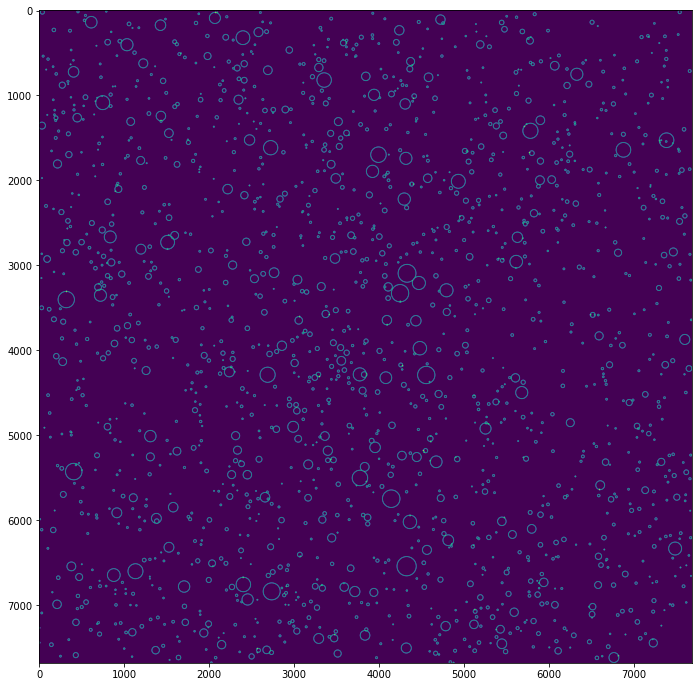

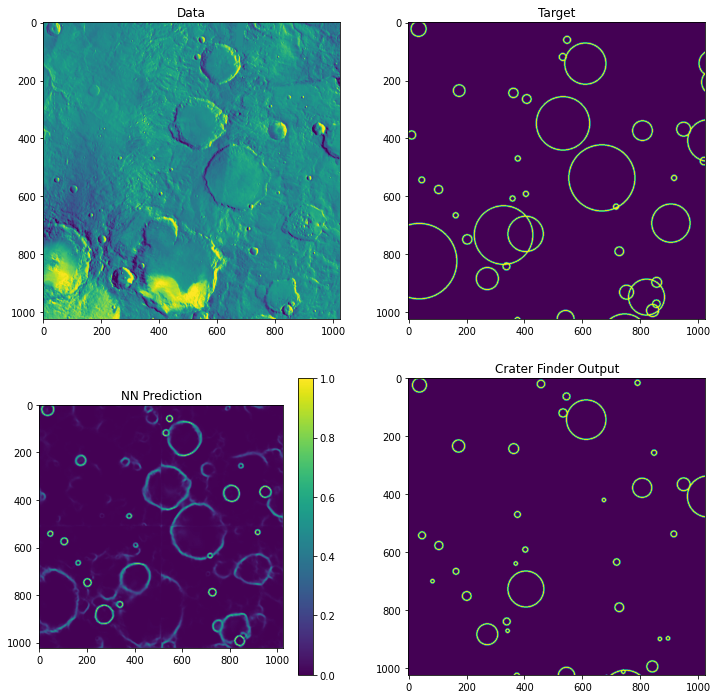

(array([[0.18650092, 0.13094845, 0.10123494, ..., 0.05839821, 0.0817729 ,
         0.12164676],
        [0.16183257, 0.11256932, 0.08371279, ..., 0.03766771, 0.05567539,
         0.08708984],
        [0.14592139, 0.09739484, 0.07253519, ..., 0.02750304, 0.0426066 ,
         0.0656874 ],
        ...,
        [0.08946314, 0.07488987, 0.06778133, ..., 0.00820214, 0.00967154,
         0.01408235],
        [0.1100493 , 0.09776805, 0.0884035 , ..., 0.01533459, 0.01752591,
         0.02398679],
        [0.12343754, 0.11109815, 0.09506481, ..., 0.02755493, 0.03053933,
         0.04133705]]), array([[2077,   28,    6],
        [2096,   29,    6],
        [5138,  165,    6],
        ...,
        [4246, 3330,  102],
        [4554, 4292,  102],
        [4323, 6541,  113]]))

In [ ]:
run_match_one_tile(data_fn, target_fn,csv_tile )

In [ ]:
"""
If you have reached this cell we thank you deeply for checking on our work and do not hesitate to contact us about any inquieries or advices we would love to hear feedback about our
humble piece of work 
NOTE : the reproducing of this work was made under the TSYP X CS challenge and the attached resources will be found in the readmefile 
"""